Function: Used this notebook to find the dementia-cv risk quantiles where most of a population is. This will help us narrow the part of the dementia-cv quantile area that we use in trials. This notebook was used first and then followed by findZeroAbsEffectSizes to further narrow the part of the risk quantiles area we use in trials.

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt

In [49]:
%matplotlib notebook
%matplotlib inline
%autosave 120

Autosaving every 120 seconds


In [ ]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
ax = Axes3D(fig)

In [3]:
from microsim.bp_treatment_strategies import *

from microsim.outcome_model_repository import OutcomeModelRepository
from microsim.outcome_model_type import OutcomeModelType
from microsim.person import Person

from microsim.population import NHANESDirectSamplePopulation

from microsim.bp_treatment_strategies import SprintTreatment

from microsim.sim_settings import simSettings

from microsim.trials.trialset import TrialsetParallel, TrialsetSerial
from microsim.trials.trial_description import TrialDescription
from microsim.trials.logistic_regression_analysis import LogisticRegressionAnalysis
from microsim.trials.linear_regression_analysis import LinearRegressionAnalysis
from microsim.trials.outcome_assessor import OutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AttributeOutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AssessmentMethod
from microsim.trials.risk_filter import RiskFilter
from microsim.trials.trial_utils import get_analysis_name, randomizationSchema

In [7]:
#any microsim dir will work, just need to access the NHANES data
#microsimDir = "/users/PAS2164/deligkaris/MICROSIM/CODE/microsim"
microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)
imputedDataset = pd.read_stata(microsimDir + "/microsim/data/fullyImputedDataset.dta")
dataDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA"

In [5]:
#at the beginning turn on pandarallel if you are planning to use TrialsetSerial
pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel

In [6]:
%%time
#with pandarallel on these two steps are faster
#12min with 10,000, 22min with 20,000, 61min with 60,000, 102min with 100,000, 160min with 150,000
#osc: 27min with 10,000
pop = NHANESDirectSamplePopulation(150000, 1999)
alive, df = pop.advance_vectorized(200)

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold)

CPU times: user 1h 54min 39s, sys: 9min 41s, total: 2h 4min 20s
Wall time: 2h 38min 42s


In [15]:
def getDFForPersonCol(person):
    df = pd.DataFrame(person.get_final_wave_state_as_dict())
    df['dfIndex'] = person.dfIndex
    df['cvRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person, args=(OutcomeModelType.CARDIOVASCULAR, 1, True), axis='columns')
    df['demRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person,  args=(OutcomeModelType.DEMENTIA, 1, True), axis='columns')
    return df

dfs = pop._people.apply(getDFForPersonCol)

In [16]:
allAgesDF = pd.concat(dfs.tolist())

In [289]:
#remove rows that represent the year the person died because the get_final_wave_state_as_dict function
#returns their age for that year to be -1 and that significantly distors their risks
allAgesDF = allAgesDF.loc[allAgesDF["alive"]==True]

In [ ]:
#allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk'].count(), allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk']

In [290]:
#if some points are outside of the min and max then qcut will return them to belong in NaN
allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk'] = 1

In [20]:
#allAgesDF.demRisk.describe(), allAgesDF.cvRisk.describe()

In [291]:
nQuantiles = 40
increment = 1.0/nQuantiles
#qcut will move the left boundary to a value lower than the min, so that the left end (which is open)
#will include the min
#we need to have n+1 points in order to have n intervals
allAgesDF['demRiskQuantile'] = pd.qcut(allAgesDF.demRisk, np.arange(0, 1.0+increment, increment))
allAgesDF['cvRiskQuantile'] = pd.qcut(allAgesDF.cvRisk, np.arange(0, 1.0+increment, increment))

In [292]:
#there should not be any NaNs
allAgesDF['demRiskQuantile'].isna().sum(), allAgesDF['cvRiskQuantile'].isna().sum()

(0, 0)

In [293]:
meanDemRiskForQuantile = allAgesDF.groupby('demRiskQuantile')['demRisk'].mean()
meanCVRiskForQuantile = allAgesDF.groupby('cvRiskQuantile')['cvRisk'].mean()

meanDemRiskForQuantileDict = {index : value for index, value in meanDemRiskForQuantile.items()}
meanCVRiskForQuantileDict = {index : value for index, value in meanCVRiskForQuantile.items()}

demQuantileNumberForQuantile = {quantile : index for index, quantile 
                                in enumerate(allAgesDF['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileNumberForQuantile = {quantile : index for index, quantile 
                               in enumerate(allAgesDF['cvRiskQuantile'].value_counts(sort=False).index)}

demQuantileForNumber = {index : quantile for index, quantile 
                        in enumerate(allAgesDF['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileForNumber = {index : quantile for index, quantile 
                       in enumerate(allAgesDF['cvRiskQuantile'].value_counts(sort=False).index)}

In [294]:
allAgesDF['meanDemRiskForQuantile'] = allAgesDF['demRiskQuantile']
allAgesDF['meanDemRiskForQuantile'].replace(meanDemRiskForQuantileDict, inplace=True)
allAgesDF['meanCVRiskForQuantile'] = allAgesDF['cvRiskQuantile']
allAgesDF['meanCVRiskForQuantile'].replace(meanCVRiskForQuantileDict, inplace=True)

allAgesDF['cvQuantileNum'] = allAgesDF['cvRiskQuantile']
allAgesDF['cvQuantileNum'].replace(cvQuantileNumberForQuantile, inplace=True)
allAgesDF['demQuantileNum'] = allAgesDF['demRiskQuantile']
allAgesDF['demQuantileNum'].replace(demQuantileNumberForQuantile, inplace=True)

In [210]:
### next step is to see how this varies by age...
### if we have wide distribution, then we can just go through deciles or something like that for trial sampling!

In [295]:
#with this approach we count the person-years and make quantiles based on these
countPersonYearsByRisks = allAgesDF.groupby(
                            ['demQuantileNum', 'cvQuantileNum'],
                            sort=True
                            )['age'].count().unstack(fill_value=0).stack() #age is not important, just choose1column

countPersonYearsByRisksDF = pd.DataFrame(
                                {'demRisk' : countPersonYearsByRisks.index.get_level_values("demQuantileNum"),
                                 'cvRisk' : countPersonYearsByRisks.index.get_level_values("cvQuantileNum"),
                              'ageCount' : countPersonYearsByRisks.values})
#countPersonYearsByRisksDF

In [297]:
#with this approach we count NHANES indices and make quantiles based on these
countIndexByRisks = allAgesDF.groupby(['demQuantileNum','cvQuantileNum'],sort=False
                                )['dfIndex'].nunique().unstack(fill_value=0).stack()

countIndexByRisksDF = pd.DataFrame({'demRisk' : countIndexByRisks.index.get_level_values("demQuantileNum"),
                              'cvRisk' : countIndexByRisks.index.get_level_values("cvQuantileNum"),
                              'indexCount' : countIndexByRisks.values})
#countIndexByRisksDF

In [298]:
#used in plots later
X=np.arange(0,nQuantiles,1)
Y=np.arange(0,nQuantiles,1)
X, Y = np.meshgrid(X, Y)
X.shape

(40, 40)

In [299]:
#this is done just in case the quantile categories are not ordered properly
countPersonYearsByRisksArray=np.zeros(X.shape)
for i,j,k in zip(countPersonYearsByRisksDF["demRisk"].values,
                 countPersonYearsByRisksDF["cvRisk"].values,
                 countPersonYearsByRisksDF["ageCount"].values):
    countPersonYearsByRisksArray[i,j]=k #i : demRisk, j: cvRisk
#countByRisksArray

In [300]:
#this is done just in case the quantile categories are not ordered properly
countIndexByRisksArray=np.zeros(X.shape)
for i,j,k in zip(countIndexByRisksDF["demRisk"].values,
                 countIndexByRisksDF["cvRisk"].values,
                 countIndexByRisksDF["indexCount"].values):
    countIndexByRisksArray[i,j]=k
#countByRisksArray

In [301]:
ageCountSum = countPersonYearsByRisksDF["ageCount"].sum() #sum of all person-ages
ageCountSumPerQbox = ageCountSum/(nQuantiles)/(nQuantiles) # of person-ages in one qq category, uniform ditribution
ageCountSum, ageCountSumPerQbox

(5912319, 3695.199375)

In [302]:
indexCountSum = countIndexByRisksDF["indexCount"].sum() #sum of all person-ages
indexCountSumPerQbox = indexCountSum/(nQuantiles)/(nQuantiles) # of person-ages in one qq category, uniform ditribution
indexCountSum, indexCountSumPerQbox

(1287599, 804.749375)

In [305]:
percentCutoffPersonYears = 0.5 #relevant to a uniform distribution, which qq categories to keep
cutoffPersonYears = (ageCountSumPerQbox * percentCutoff)
cutoffPersonYears

1847.5996875

In [306]:
percentCutoffIndex = 0.5 #relevant to a uniform distribution, which qq categories to keep
cutoffIndex = (indexCountSumPerQbox * percentCutoffIndex)
cutoffIndex

402.3746875

In [308]:
#by including the quantile-quantile boxes that are above the cutoff, we include
#this percentage of all person years
qqcategoriesToIncludePersonYears = countPersonYearsByRisksDF.loc[
                                            countPersonYearsByRisksDF["ageCount"] > cutoffPersonYears] 
qqcategoriesToIncludePersonYears["ageCount"].sum()/ageCountSum #percent of person-ages included

0.9513615554235149

In [309]:
#by including the quantile-quantile boxes that are above the cutoff, we include
#this percentage of all NHANES indices
qqcategoriesToIncludeIndex = countIndexByRisksDF.loc[countIndexByRisksDF["indexCount"] > cutoffIndex] 
qqcategoriesToIncludeIndex["indexCount"].sum()/indexCountSum #percent of person-ages included

0.9503913873806985

In [343]:
#to see how array maps to the figure, see:https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html

<IPython.core.display.Javascript object>


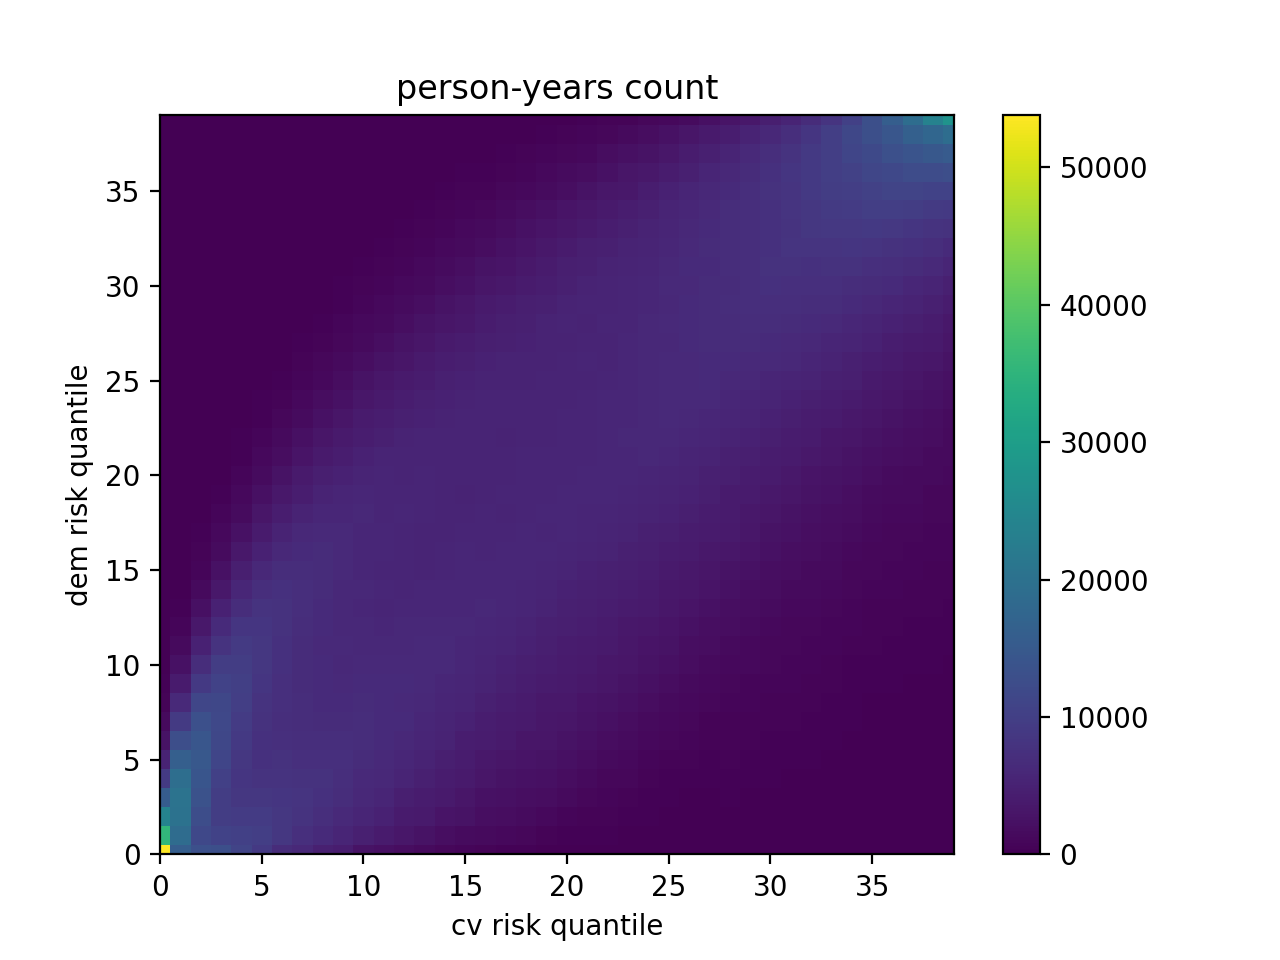

In [310]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countPersonYearsByRisksArray, shading='nearest')
ax.set_title('person-years count')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
#for some reason I need to run this in order to make the next graphs interactive
#%matplotlib qt

<IPython.core.display.Javascript object>


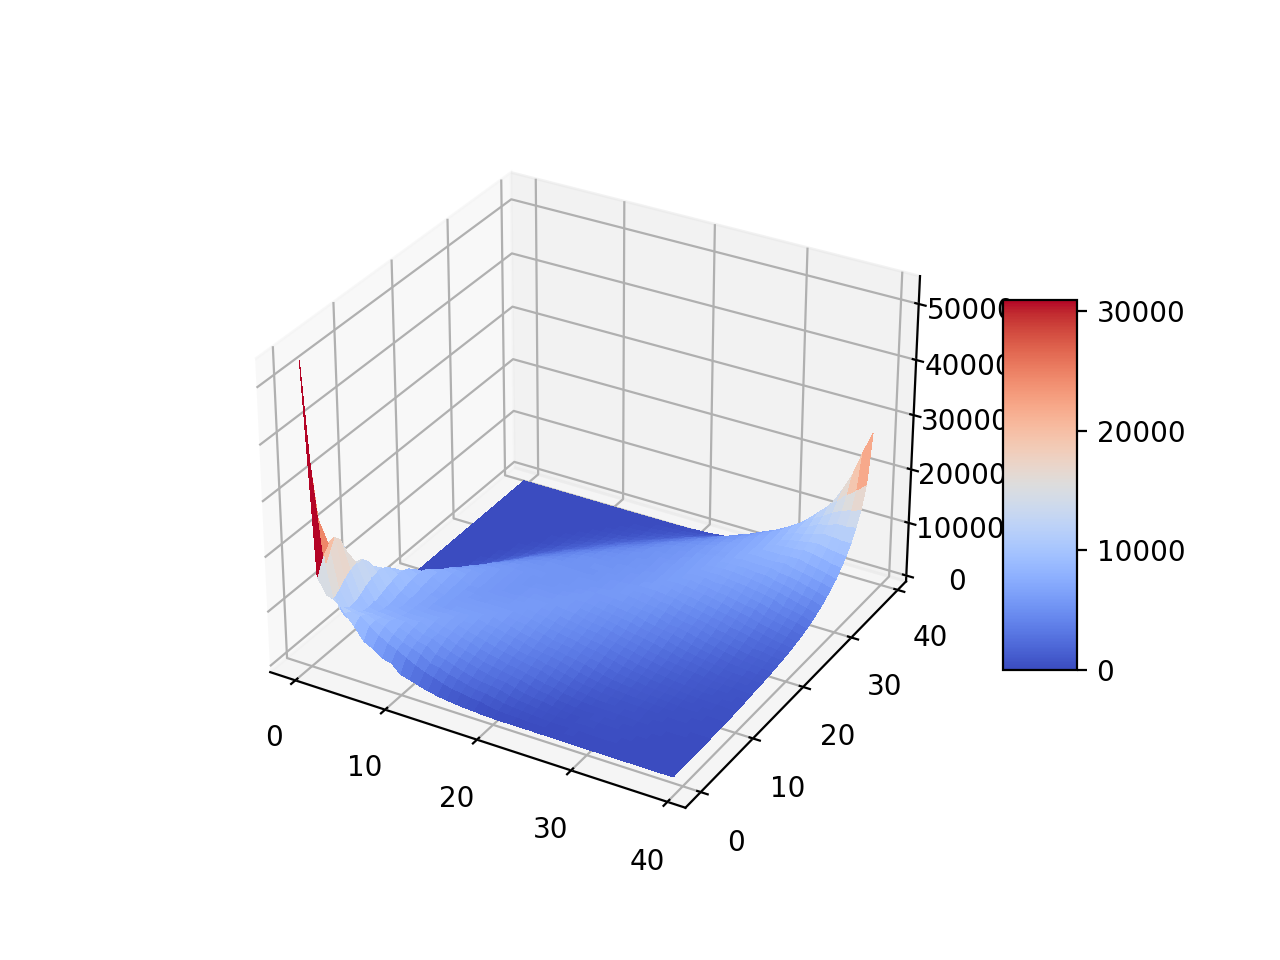

In [321]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, countPersonYearsByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


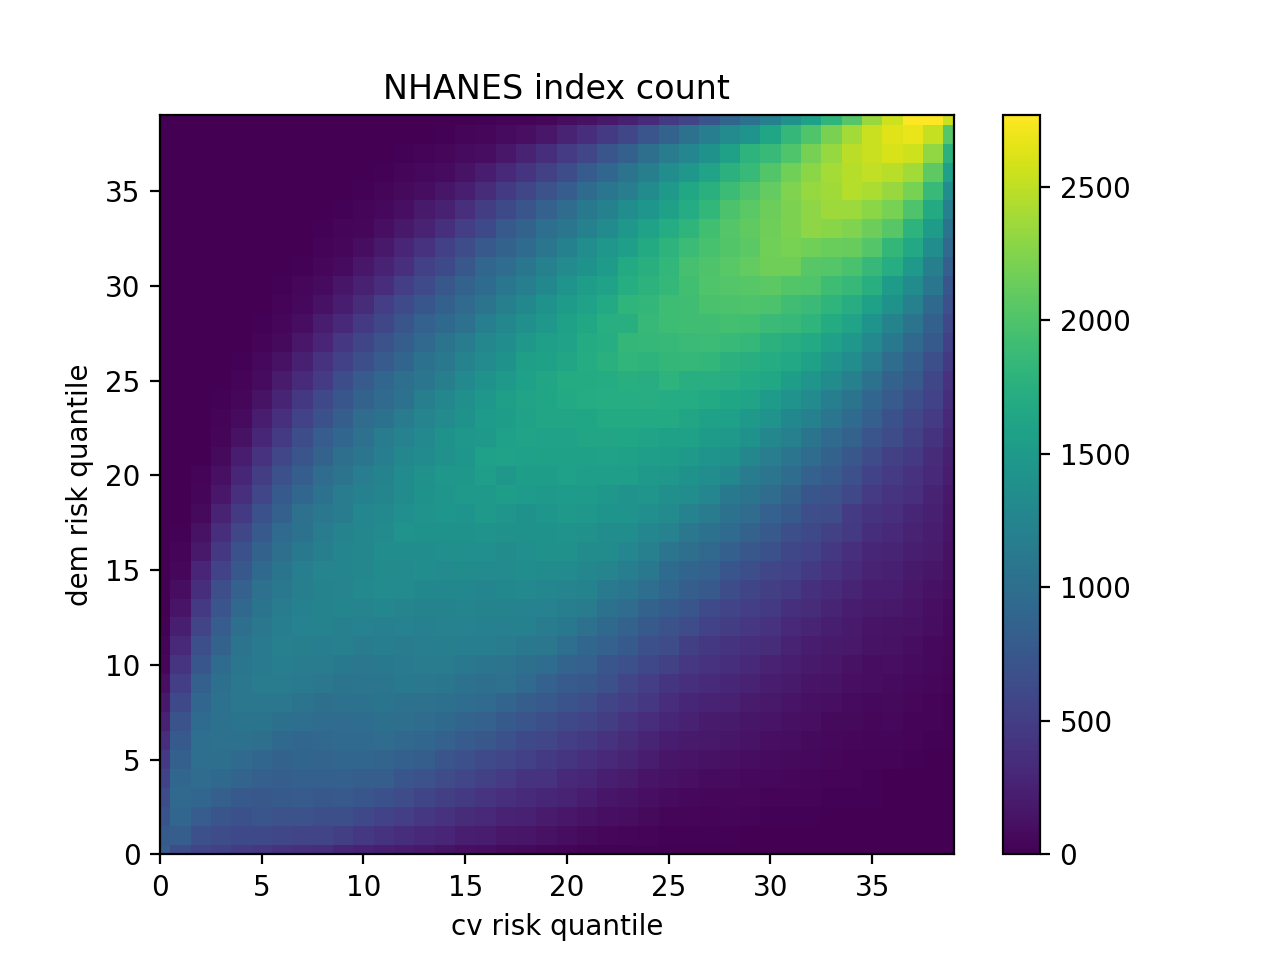

In [320]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countIndexByRisksArray, shading='nearest')
ax.set_title('NHANES index count')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

<IPython.core.display.Javascript object>


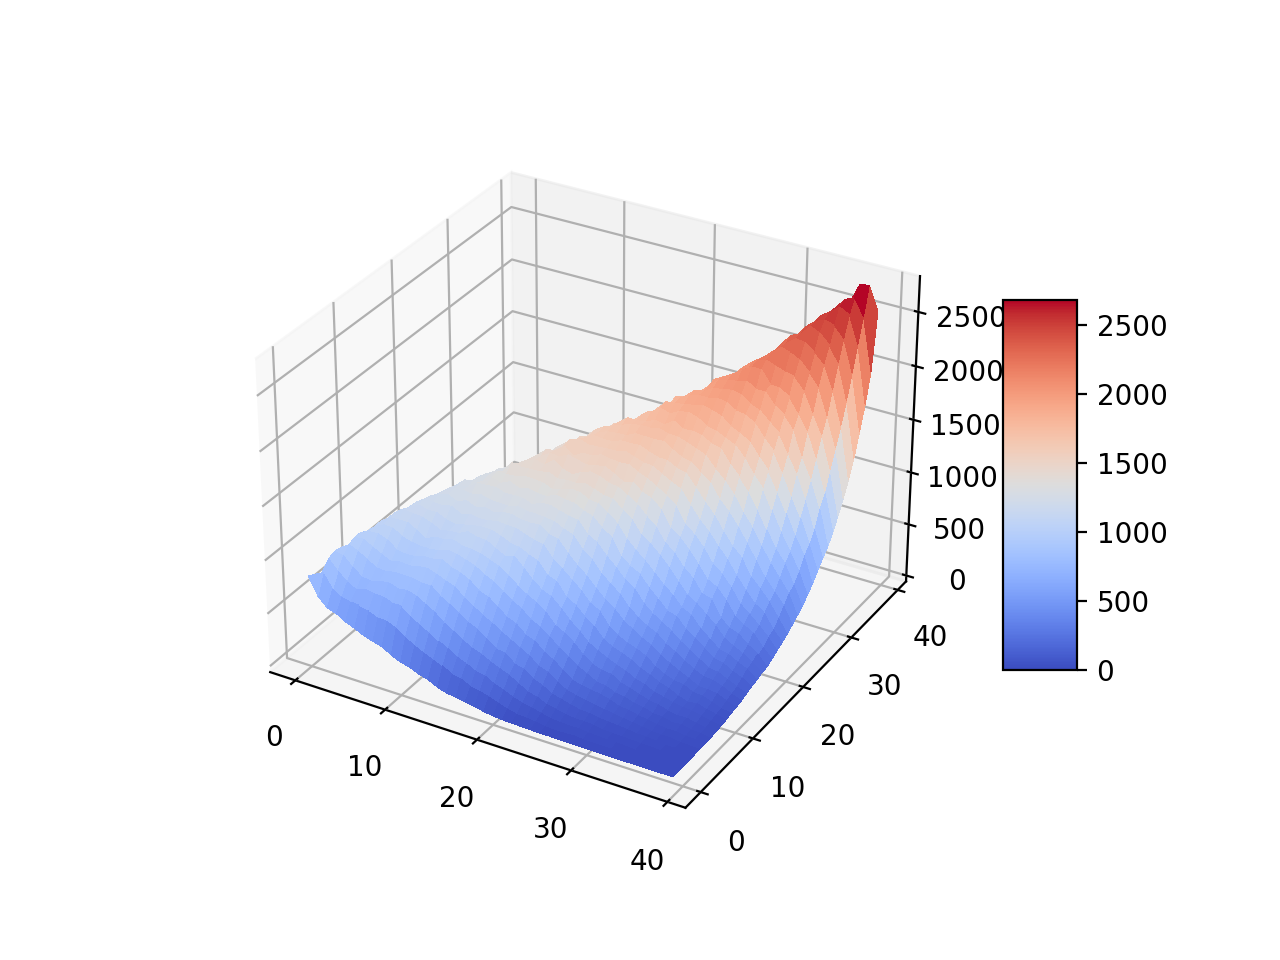

In [322]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, countIndexByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [313]:
# decide on which quantiles to keep

#based on person-years
includedPersonYears = np.zeros(X.shape)
for i, j in zip(qqcategoriesToIncludePersonYears["demRisk"],qqcategoriesToIncludePersonYears["cvRisk"]):
    includedPersonYears[i,j]=1
    
#and based on NHANES indices
includedIndex = np.zeros(X.shape)
for i, j in zip(qqcategoriesToIncludeIndex["demRisk"],qqcategoriesToIncludeIndex["cvRisk"]):
    includedIndex[i,j]=1

<IPython.core.display.Javascript object>


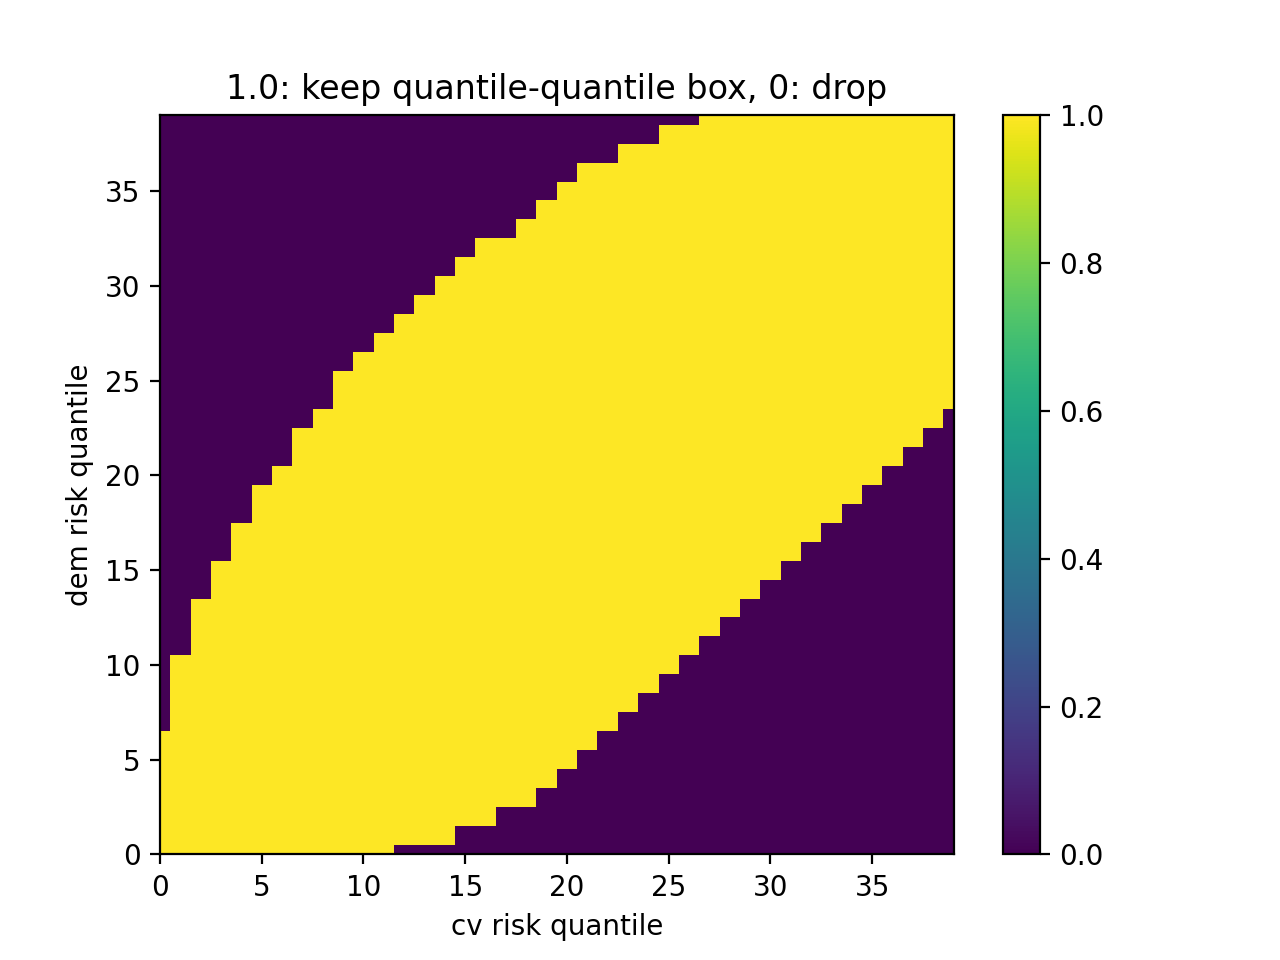

In [323]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, includedPersonYears, shading='nearest')
ax.set_title('1.0: keep quantile-quantile box, 0: drop')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

<IPython.core.display.Javascript object>


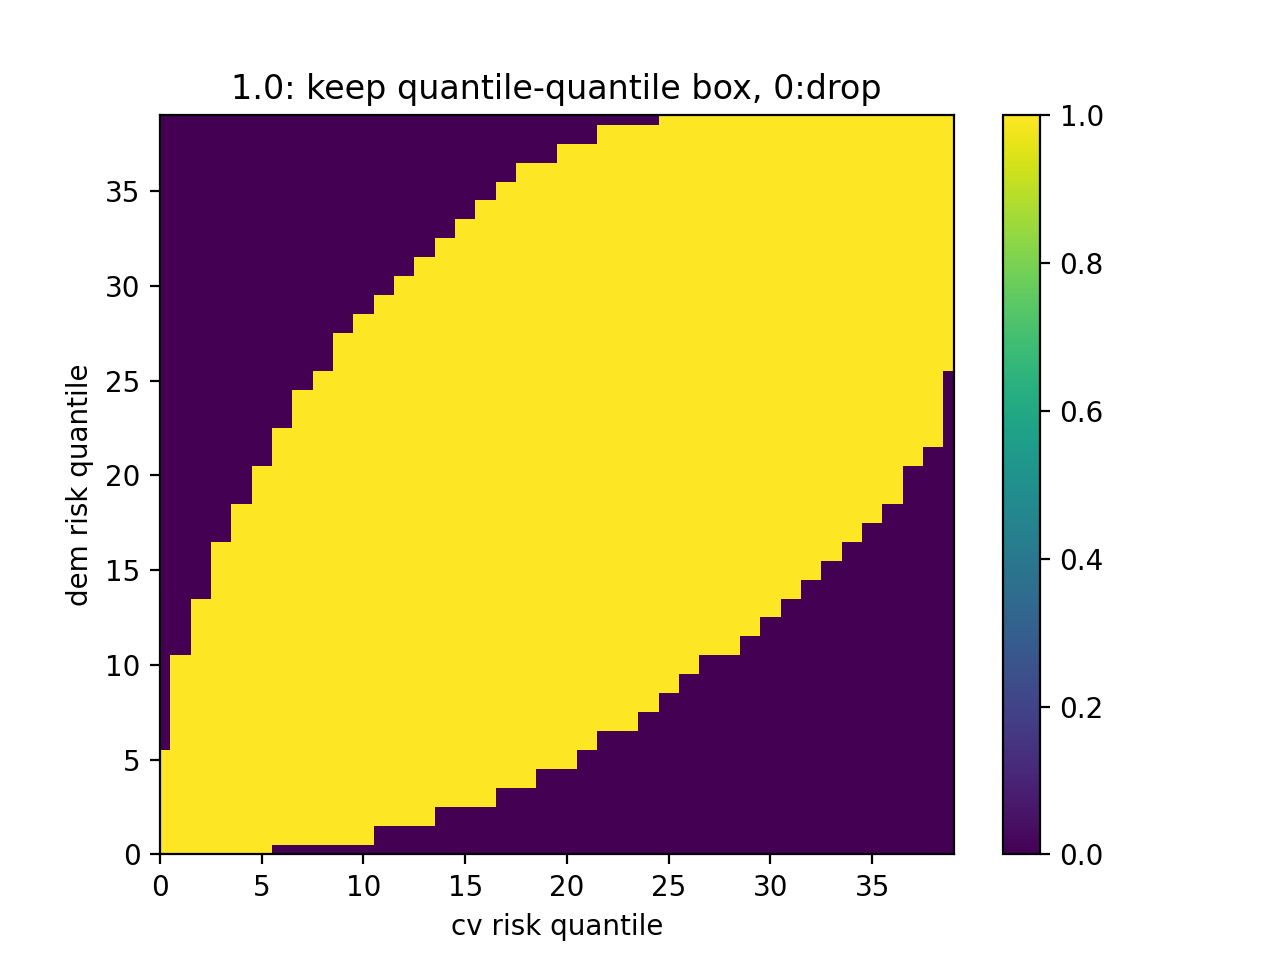

In [324]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, includedIndex, shading='nearest')
ax.set_title('1.0: keep quantile-quantile box, 0:drop')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [325]:
#now we will export the quantiles we have found
#depending on how we want to proceed we may export all quantiles-quantiles or
#just the ones that meet the person-year cutoff or the NHANES index cutoff
#for now, we will export all quantiles-quantiles

In [326]:
demQuantiles = allAgesDF.demRisk.quantile(np.arange(0, 1+increment, increment).tolist())
cvQuantiles = allAgesDF.cvRisk.quantile(np.arange(0, 1+increment, increment).tolist())
quantileDF = pd.DataFrame(index=demQuantiles.index, data={'dementia' : demQuantiles.values, 'cv' : cvQuantiles.values})
#quantileDF

In [328]:
#make the lower end of the quantiles for dementia and cv exactly 0
#
quantileDF.loc[0,"dementia"]=0
quantileDF.loc[0,"cv"]=0
#quantileDF

In [329]:
quantileDF.shape

(41, 2)

In [137]:
#if you want to verify the quantile calculation above
#allAgesDF.demRisk.describe(), allAgesDF.cvRisk.describe()

In [330]:
qqcategoriesToIncludePersonYears.reset_index(drop=True,inplace=True)

qqcategoriesToIncludePersonYears.drop(["ageCount"],inplace=True,axis=1)

qqcategoriesToIncludePersonYears["demRiskLowerLimit"] = quantileDF.iloc[
                                                qqcategoriesToIncludePersonYears["demRisk"].to_list()
                                            ]["dementia"].reset_index(drop=True)
qqcategoriesToIncludePersonYears["cvRiskLowerLimit"] = quantileDF.iloc[
                                                qqcategoriesToIncludePersonYears["cvRisk"].to_list()
                                            ]["cv"].reset_index(drop=True)

In [337]:
#qqcategoriesToIncludePersonYears.transpose().head()

In [335]:
qqcategoriesToIncludePersonYears.transpose().shape

(4, 969)

In [338]:
#qqcategoriesToIncludePersonYears.head()

In [340]:
#if you want to export the quantiles to use based on a cutoff
#qqcategoriesToIncludePersonYears.to_csv(dataDir + "/dementiaAndCVQuantilesToInclude.csv")

In [339]:
#if you want to export all quantiles
quantileDF.to_csv(dataDir + "/dementiaAndCVQuantileThresholds.csv")

In [342]:
#import pickle
#with open(dataDir + "/demQuantileNumberForQuantile.pickle","wb") as file:
#    pickle.dump(demQuantileNumberForQuantile,file)
#with open(dataDir + "/cvQuantileNumberForQuantile.pickle","wb") as file:
#    pickle.dump(cvQuantileNumberForQuantile,file)